In [1]:
import sys  
sys.path.insert(0, 'kpic_pipeline/kpicdrp/') #this sets ?the f?ile path that I need I think

In [2]:
!pwd

/Users/emac/kpic_pipeline/kpicdrp


In [3]:
#These are all the important imports for the KPIC Data Reduction Pipeline 
from kpicdrp.caldb import det_caldb, trace_caldb
# import background_demo
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from kpicdrp.data import DetectorFrame
from glob import glob
import os
from kpicdrp import background
import matplotlib.pyplot as plt
import sys 
import numpy as np
from kpicdrp.data import Dataset, DetectorFrame
from kpicdrp.caldb import det_caldb
from pipeline_utils import get_filenums, get_filelist
#These are the inputs for the telluric/rv trace finding
import kpicdrp.trace as trace
import kpicdrp.extraction as extraction
import kpicdrp.trace as trace
# import kpicdrp.extraction as extraction
import kpicdrp.utils as utils
import kpicdrp.data as data

# General Steps for Data Reduction:
3.1.1. Background/Bad Pixel Finding

3.1.2. Telluric/RV Trace Finding

3.1.3. RV Standard Flux Extraction

3.1.4. RV Standard Wavelength Calibration

3.1.5. Target Flux Extraction

3.1.6. Cross Correlation

### Step 1: Compute master background and bad pixel map from background images. I think the secondary goal is to remove the thermal backround and bad pixels, but first I need a master background?
$\textbf{Goal:}$ Identify which nspec files are Background exposures via the nightly logs. Make a KPIC Campaign Calibration folder and copy valid background files for the night

In [4]:
obsdate = input("Enter UT Date (e.g.20220723) >>> ")
# obsdate = obsdate.strip()
obsdate = '20211022'
#Should be 20211022 for my target
#print(obsdate)
main_calibdir = os.path.join("/Users/emac/kpic_pipeline/kpicdrp/IRXS/20211022/", obsdate) #Main Calibration Directory

Enter UT Date (e.g.20220723) >>>  20211022


In [5]:
# raw_datadir = os.path.join("/Users/phillips.1622/Dropbox/KPIC_Work/IRXS/", obsdate[2:], "spec")#Raw Data Directory
raw_datadir = os.path.join("IRXS/","spec")#Raw Data Directory
print(raw_datadir)

filestr = "nspec"+ str(int(obsdate[2:])) +"_{0:4d}.fits"
print(filestr)

IRXS/spec
nspec211022_{0:4d}.fits


In [6]:
str(int(obsdate[2:]))

'211022'

In [7]:
str(int(obsdate[2:]))

'211022'

In [8]:
# background_directory=os.path.join("/Users/phillips.1622/Dropbox/kpic_pipeline/20211022")
# bkgddir = os.path.join(background_directory, "bkgd_bpmap/") # background file directory map
bkgddir = os.path.join(main_calibdir, "bkgd_bpmap/") # main data dir
print(bkgddir)

/Users/emac/kpic_pipeline/kpicdrp/IRXS/20211022/20211022/bkgd_bpmap/


In [9]:
# check if raw directory exists. If not, create it and pull files over
raw_dir = os.path.join(bkgddir,"raw")
#raw_dir = os.path.join(bkgddir,"raw")
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

To use these scripts, you can create a folder in /calibs/ called 20221022. Then make a file following the example of calib_info.py for you night.  E.g. looks like in your case, the RV calibrator is HIP95771, with frames 1170-1182.  So overwrite the names and file ranges in the calib_info.py file below

In [10]:
# read calib config file
sys.path.insert(1, main_calibdir)
from calib_info import calib_info
print('Loaded calibration config file for ' + obsdate)
filenums = get_filenums(calib_info['raw_bkgd_range'])

Loaded calibration config file for 20211022
29 of files identified:
[1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107
 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121
 1122]


In [11]:
calib_info['raw_bkgd_range']

[(1094, 1122)]

In [12]:
def get_filelist(raw_dir, filenums, filestr, raw_datadir):
    filelist = glob(os.path.join(raw_dir, "*.fits"))

    print(len(filelist), len(filenums))

    # just return the files if nodsub
    if 'raw_pairsub' in raw_dir:
        return filelist

    elif len(filelist) != len(filenums):
        for fnum in filenums:
            fname = os.path.join(raw_datadir, filestr.format(fnum))
            print('Moving '  + fname)
            command = "rsync -a -u --ignore-existing " + fname + " " + raw_dir
            os.system(command)
        
        # remake filelist if this is the case
        #filelist = glob(os.path.join(raw_dir, "*.fits"))

        # only get files corresponding to input filenums
        filelist = [ os.path.join(raw_dir, filestr.format(i)) for i in filenums]

    print(len(filelist))

    return filelist

In [13]:
## Hack up here ##
filelist = get_filelist(raw_dir, filenums, filestr, raw_datadir)

29 29
29


In [14]:
# For multiple tint and coadds in one folder
# It will save the master backgrounds and bad pixel maps to bkgddir.
raw_dataset = Dataset(filelist=filelist, dtype=DetectorFrame)
master_bkgds, badpixmaps, unique_tint, unique_coadds = background.process_backgrounds(raw_dataset, save_loc=bkgddir, fileprefix=obsdate, caldb_save_loc=det_caldb)


2024-09-09 20:15:04,091 nspec211022_1119.fits
2024-09-09 20:15:04,091 nspec211022_1115.fits
2024-09-09 20:15:04,092 nspec211022_1103.fits
2024-09-09 20:15:04,092 nspec211022_1102.fits
2024-09-09 20:15:04,093 nspec211022_1114.fits
2024-09-09 20:15:04,093 nspec211022_1118.fits
2024-09-09 20:15:04,093 nspec211022_1122.fits
2024-09-09 20:15:04,094 nspec211022_1095.fits
2024-09-09 20:15:04,094 nspec211022_1113.fits
2024-09-09 20:15:04,095 nspec211022_1105.fits
2024-09-09 20:15:04,095 nspec211022_1099.fits
2024-09-09 20:15:04,096 nspec211022_1109.fits
2024-09-09 20:15:04,096 nspec211022_1108.fits
2024-09-09 20:15:04,097 nspec211022_1098.fits
2024-09-09 20:15:04,097 nspec211022_1104.fits
2024-09-09 20:15:04,098 nspec211022_1112.fits
2024-09-09 20:15:04,098 nspec211022_1094.fits
2024-09-09 20:15:04,099 nspec211022_1107.fits
2024-09-09 20:15:04,099 nspec211022_1111.fits
2024-09-09 20:15:04,099 nspec211022_1097.fits
2024-09-09 20:15:04,100 nspec211022_1096.fits
2024-09-09 20:15:04,100 nspec21102

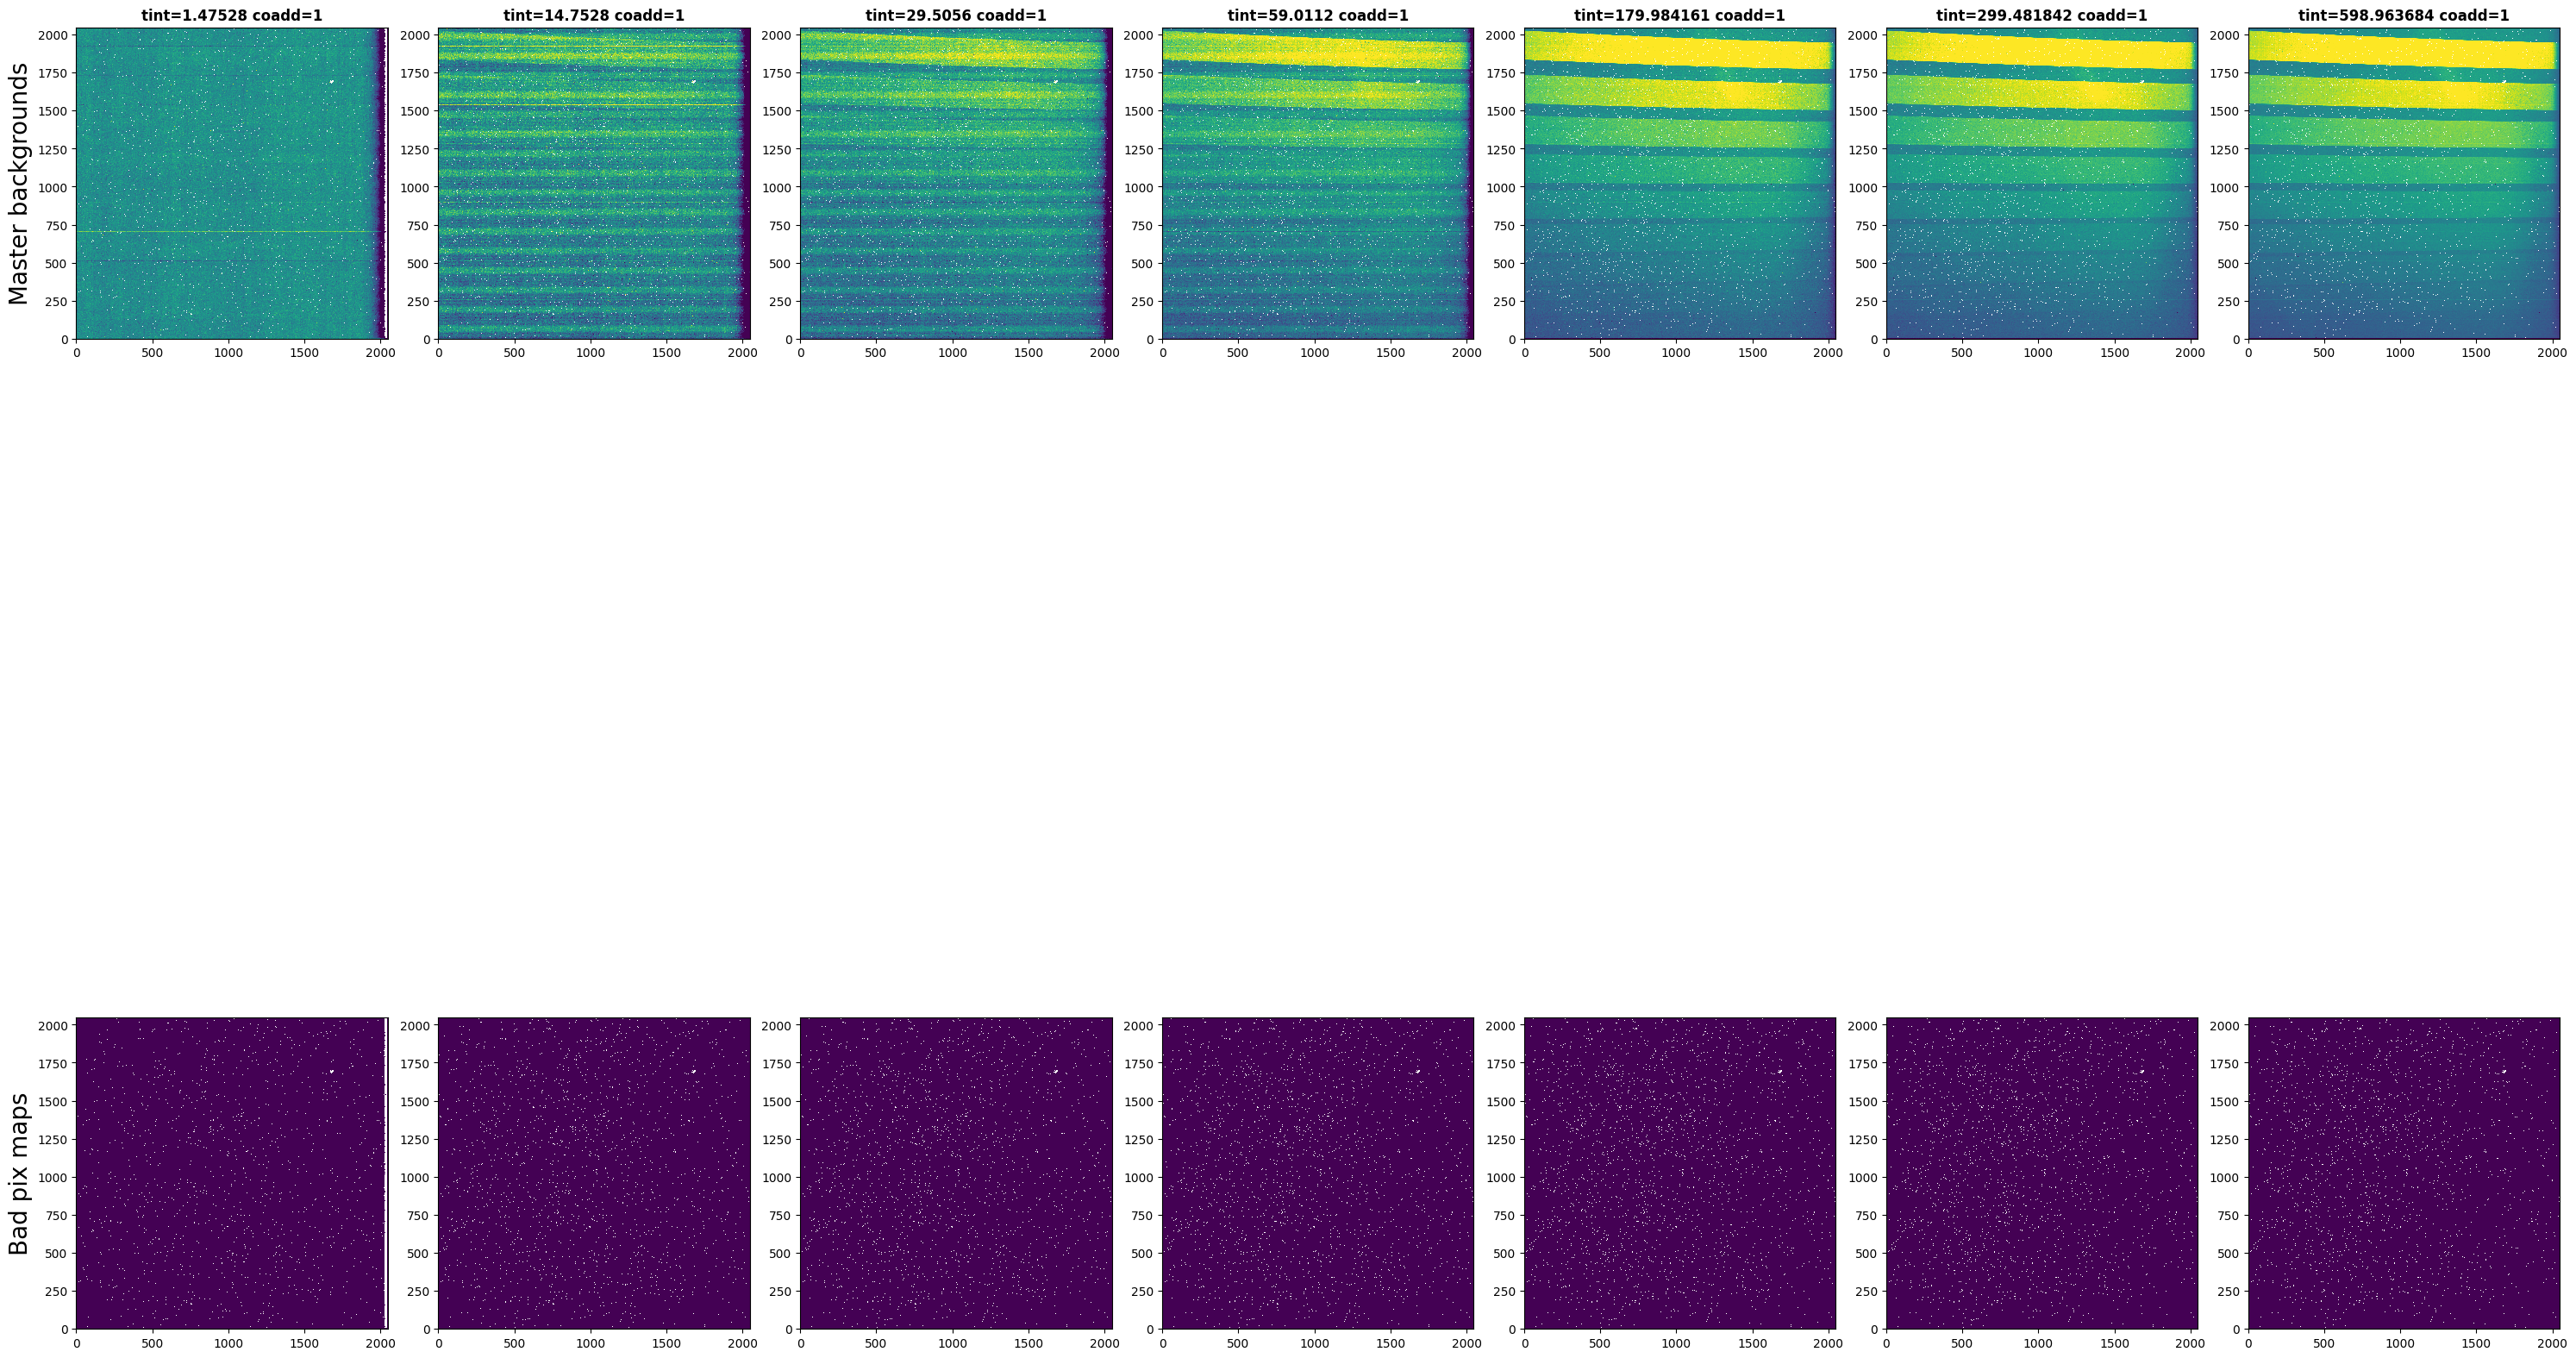

In [15]:
# Plot the resulting master backgrounds and bad pixels
f = plt.figure(figsize=(10,9))
# plt.tight_layout(pad=3.0,w_pad=5)


 
# to change size of subplot's
# set height of each subplot as 8
f.set_figheight(30)
 # set width of each subplot as 8
f.set_figwidth(30)
# ax = f.add_subplot(121)
# ax2 = f.add_subplot(122)
for k,(background_med,badpixmap, tint,coadd) in enumerate(zip(master_bkgds,badpixmaps,unique_tint,unique_coadds)):
#     print(k) #commenting this out for now
#     ax = f.add_subplot(121)
    plt.subplot(2,len(master_bkgds),k+1)

    plt.title("tint={0} coadd={1}".format(tint,coadd),fontsize=12,weight='bold')
    plt.imshow(background_med.data, interpolation="nearest", origin="lower")
    med_val = np.nanmedian(background_med.data)
    plt.clim([0,2*med_val])

    plt.subplot(2,len(master_bkgds),k+len(master_bkgds)+1)
    plt.imshow(badpixmap.data, interpolation="nearest", origin="lower")
plt.subplot(2,len(master_bkgds),1)
plt.ylabel("Master backgrounds",fontsize=20)
plt.subplot(2,len(master_bkgds),len(master_bkgds)+1)
plt.ylabel("Bad pix maps",fontsize=20)
plt.tight_layout(h_pad=5,w_pad=0.2)

plt.savefig(os.path.join(bkgddir, 'bkgd_bpmap.png'), dpi=200 )
plt.show()

### Step 2: Telluric/RV Trace Finding
 $\textbf{Goal:}$ Identify which nspec files are Telluric calibrator exposures via nightly log
3.3.2. Make a KPIC Campaign Calibration folder for trace and copy valid data


In [16]:
try:
    import mkl
    mkl.set_num_threads(12)
except:
    pass

# HIP56147 is for HIP 55507
# HIP95771 is for HD 4747
# HD 4622 is for 2M0122
# HIP62944 for 20210424
# ups Her for 20210715
# obsdate = "20200701"

In [17]:
obsdate = input("Enter UT Date (e.g.20220723) >>> ")
#Should be 20211022
obsdate = obsdate.strip()
print(obsdate)

Enter UT Date (e.g.20220723) >>>  20211022


20211022


In [18]:
#Redefining where the directories are at
raw_datadir = os.path.join("IRXS/","spec")#Raw Data Directory
main_calibdir = os.path.join("kpic_pipeline/kpicdrp/IRXS/20211022/", obsdate) #Main Calibration Directory
filestr = "nspec"+ str(int(obsdate[2:])) +"_{0:04d}.fits"

In [19]:
# read calib config file
sys.path.insert(1, main_calibdir)
from calib_info import calib_info
print('Loaded calibration config file for ' + obsdate)
trace_star = calib_info['trace_star']

Loaded calibration config file for 20211022


In [20]:
# Figure out raw files for the derivation of the trace which are the telluric calibrator
### I think these are the right files
filenums = get_filenums(calib_info['raw_trace_range'])

9 of files identified:
[1183 1184 1185 1186 1187 1188 1189 1190 1191]


In [21]:
# trace_star_dir = os.path.join("/scr3/kpic/KPIC_Campaign/science", trace_star, obsdate)
trace_star_dir = os.path.join("IRXS/","spec") #Trace Star Directory should be 1183 - 1191
print(trace_star_dir)
# check if raw directory exists. If not, create it and pull files over
raw_dir = os.path.join(trace_star_dir, "raw")
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

IRXS/spec


In [22]:
# Only copy files if there are less files in raw dir than bkgd filenums
filelist = get_filelist(raw_dir, filenums, filestr, raw_datadir)

9 9
9


In [23]:
# Set output directory
out_trace_dir = os.path.join(main_calibdir, "trace")
if not os.path.exists(os.path.join(out_trace_dir)):
    os.makedirs(os.path.join(out_trace_dir))
# save starname used for the trace
outfilename = os.path.join(trace_star+"_trace.fits")

In [24]:
outfilename

'lamCap_trace.fits'

In [25]:
# If True, it automatically derives a first guess for the traces location using kpicdrp.trace.fibers_guess() using
# some peak fitting routine.
make_guess = True
N_order = 9
# Set number of threads to be used
numthreads = 12

# read in the raw data
input_data = data.Dataset(filelist=filelist, dtype=data.DetectorFrame)

In [26]:
input_data[0]

In [27]:
# master background and bad pix directory
bkgd = det_caldb.get_calib(input_data[0], type="Background")
badpixmap = det_caldb.get_calib(input_data[0], type="BadPixelMap")

In [28]:
#Read the raw detector images into a cube while subtracting background
cleaned_data = extraction.process_sci_raw2d(input_data, bkgd, badpixmap, detect_cosmics=True, add_baryrv=False)

/Users/emac/kpic_pipeline/kpicdrp/extraction.py:71: RuntimeWarning: invalid value encountered in sqrt
  noise_e = np.sqrt(var_e)


In [29]:
# Define the first guess for the trace location
if make_guess:
    guess_fibers_params = trace.fibers_guess(cleaned_data, N_order=N_order)
else:
    fiber1 = [[70, 150], [260, 330], [460, 520], [680 - 10, 720 + 10], [900 - 15, 930 + 15], [1120 - 5, 1170 + 5],
                [1350, 1420], [1600, 1690], [1870, 1980]]
    fiber2 = [[50, 133], [240, 320], [440, 510], [650, 710], [880 - 15, 910 + 15], [1100 - 5, 1150 + 5], [1330, 1400],
                [1580, 1670], [1850, 1960]]
    fiber3 = [[30, 120], [220, 300], [420, 490], [640 - 5, 690 + 5], [865 - 20, 890 + 20], [1090 - 10, 1130 + 10],
                [1320, 1380], [1570, 1650], [1840, 1940]]

    guess_locs = []
    guess_labels = []
    for k,fiber_ends in enumerate([fiber1, fiber2, fiber3]):
        guess_locs_thisfib = []
        for ends in fiber_ends:
            num_channels = cleaned_data[0].shape[-1]
            this_order_guesspos = np.interp(np.arange(num_channels), [0, num_channels], ends)
            guess_locs_thisfib.append(this_order_guesspos)
        guess_locs.append(guess_locs_thisfib)
        guess_labels.append("s{0}".format(k + 1))

    guess_locs = np.array(guess_locs)
    guess_labels = np.array(guess_labels)
    guess_widths = np.ones(guess_locs.shape) * (3 / (2 * np.sqrt(2 * np.log(2))))
    guess_fibers_params = data.TraceParams(locs=guess_locs, widths=guess_widths, labels=guess_labels, header=cleaned_data[0].header)

/Users/emac/kpic_pipeline/kpicdrp/trace.py:164: RuntimeWarning: All-NaN slice encountered
  med_frame = np.nanmedian(fiber_dataset[file_ids].data, axis=0)


In [30]:
# Calibrate the trace position and width
trace_calib = trace.fit_trace(cleaned_data, guess_fibers_params, numthreads=numthreads, fitbackground=False)

fiber_num,fiber_list 0 ['s4' 's2' 's2' 's4' 's1' 's3' 's3' 's1' 's2']
np.where(fiber_num==fiber_list) (array([], dtype=int64),)
order_id,(y1,y2) 0 (82, 141)
order_id,(y1,y2) 1 (276, 322)
order_id,(y1,y2) 2 (480, 510)
order_id,(y1,y2) 3 (694, 707)
order_id,(y1,y2) 4 (913, 919)
order_id,(y1,y2) 5 (1136, 1154)
order_id,(y1,y2) 6 (1370, 1407)
order_id,(y1,y2) 7 (1621, 1675)
order_id,(y1,y2) 8 (1890, 1965)
fiber_num,fiber_list 1 ['s4' 's2' 's2' 's4' 's1' 's3' 's3' 's1' 's2']
np.where(fiber_num==fiber_list) (array([], dtype=int64),)
order_id,(y1,y2) 0 (64, 124)
order_id,(y1,y2) 1 (257, 304)
order_id,(y1,y2) 2 (461, 494)
order_id,(y1,y2) 3 (675, 691)
order_id,(y1,y2) 4 (896, 901)
order_id,(y1,y2) 5 (1119, 1136)
order_id,(y1,y2) 6 (1354, 1387)
order_id,(y1,y2) 7 (1603, 1657)
order_id,(y1,y2) 8 (1872, 1946)
fiber_num,fiber_list 2 ['s4' 's2' 's2' 's4' 's1' 's3' 's3' 's1' 's2']
np.where(fiber_num==fiber_list) (array([], dtype=int64),)
order_id,(y1,y2) 0 (45, 107)
order_id,(y1,y2) 1 (239, 289)
ord

In [31]:
# Smooth the trace calibrations different ways, with polyfit or with spline. Only using the spline smoothing.
smooth_trace_calib = trace.smooth(trace_calib)


trace_calib <kpicdrp.data.TraceParams object at 0x11962ee50>
paras0 [ 82.66119578  89.97821438  97.25109423 104.40492425 111.33659449
 118.10092843 124.63476227 130.96223584 136.93344859 142.41255942]
res.x [ 82.58195308  90.01121992  97.23144921 104.38914619 111.34605776
 118.12639165 124.6388452  130.92242031 136.93866046 142.60765159]
vec_hpf_std 0.06115813065281162
paras0 [0.81896337 0.83116296 0.80242546 0.79812388 0.83481929 0.89881019
 0.96367263 1.01064542 1.04528622 1.11791426]
res.x [0.82407805 0.8314543  0.8022456  0.77774717 0.85028572 0.86457812
 0.98898057 0.99360909 1.05472168 1.06718856]
vec_hpf_std 0.03353713551541266
paras0 [277.96847056 282.84365638 288.14277592 293.51787295 298.75375614
 303.86398009 308.83799394 313.75169243 318.52247075 323.01136268]
res.x [277.52545974 282.86933051 288.17661361 293.52363079 298.72937414
 303.87026874 308.86176616 313.76281252 318.49307405 323.0856134 ]
vec_hpf_std 0.07653808897602406
paras0 [1.02052807 1.05857346 0.99861002 0.966

In [32]:
# add background and dark current traces to sample the noise (optional)
smooth_trace_calib = trace.add_background_traces(smooth_trace_calib)
smooth_trace_calib.save(filedir=out_trace_dir, filename=outfilename, caldb=trace_caldb)

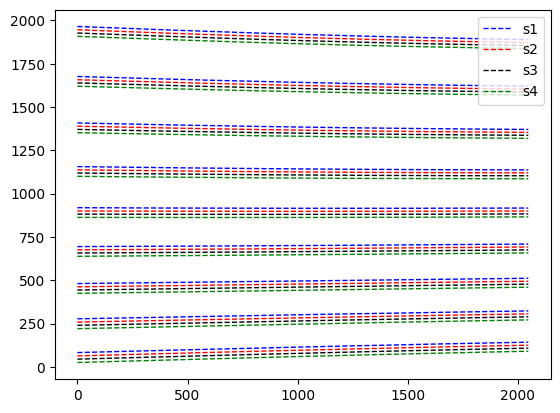

In [33]:
# Plot
trace_width = smooth_trace_calib.widths
trace_loc = smooth_trace_calib.locs

plt.figure(2)
for order_id in range(9):
    # only plot the trace of sci fibers
    for fib in range(4):
        label = smooth_trace_calib.labels[fib]
        if '1' in label:
            color = 'blue'
        elif '2' in label:
            color = 'red'
        elif '3' in label:
            color = 'black'
        elif '4' in label:
            color = 'green'
        linestyle = '--'
        if order_id == 0:
            plt.plot(trace_loc[fib, order_id, :], label=label, color=color, linestyle=linestyle, linewidth=1)
        else:
            plt.plot(trace_loc[fib, order_id, :], label='__nolegend__', color=color, linestyle=linestyle, linewidth=1)

plt.legend()
plt.savefig( os.path.join(out_trace_dir, trace_star+'_trace.png'), dpi=200 )
plt.show()

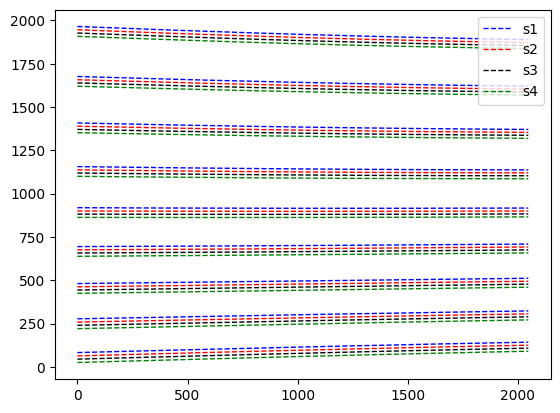

In [34]:
# Plot
trace_width = smooth_trace_calib.widths
trace_loc = smooth_trace_calib.locs

plt.figure(2)
for order_id in range(9):
    # only plot the trace of sci fibers
    for fib in range(4):
        label = smooth_trace_calib.labels[fib]
        if '1' in label:
            color = 'blue'
        elif '2' in label:
            color = 'red'
        elif '3' in label:
            color = 'black'
        elif '4' in label:
            color = 'green'
        linestyle = '--'
        if order_id == 0:
            plt.plot(trace_loc[fib, order_id, :], label=label, color=color, linestyle=linestyle, linewidth=1)
        else:
            plt.plot(trace_loc[fib, order_id, :], label='__nolegend__', color=color, linestyle=linestyle, linewidth=1)

plt.legend()
plt.savefig( os.path.join(out_trace_dir, trace_star+'_trace_version2.png'), dpi=200 )
plt.show()

### Step 3: Flux Extraction
 $\textbf{Goal:}$ Start with the wavelength calibrator/RV standard - HIP95771
#### We will extract the flux for our RV calibrator, but in general this can be for anything
#### load in the files we generated in the background_demo.py example
#### or we can load in the backup calibrations in the example data
#### you can replace with your own generated backgrounds if you would like

In [14]:
import multiprocessing as mp
mypool = mp.Pool(2)

# Public KPIC google drive
kpicpublicdir = "IRXS/HIP95771/" # main data directory 
raw_data_dir = os.path.join(kpicpublicdir, "raw") # raw 2D images
out_flux_dir = os.path.join(kpicpublicdir, "fluxes")
if not os.path.exists(os.path.join(out_flux_dir)):
    os.makedirs(os.path.join(out_flux_dir))
filelist = glob(os.path.join(raw_data_dir, "*.fits"))

In [15]:
raw_sci_dataset = data.Dataset(filelist=filelist, dtype=data.DetectorFrame)

In [16]:
# fetch calibration files
bkgd = det_caldb.get_calib(raw_sci_dataset[0], type="Background")
badpixmap = det_caldb.get_calib(raw_sci_dataset[0], type="BadPixelMap")


In [17]:
trace_dat = trace_caldb.get_calib(raw_sci_dataset[0])

In [39]:
# get background traces if they aren't there already
if 'b1' not in trace_dat.labels:
    trace_dat = trace.get_background_traces(trace_dat)

sci_dataset = extraction.process_sci_raw2d(raw_sci_dataset, bkgd, badpixmap, detect_cosmics=True, add_baryrv=True)

spectral_dataset = extraction.extract_flux(sci_dataset, trace_dat, fit_background=True, bad_pixel_fraction=0.01, pool=mypool)

spectral_dataset.save(filedir=out_flux_dir)

/Users/emac/kpic_pipeline/kpicdrp/extraction.py:71: RuntimeWarning: invalid value encountered in sqrt
  noise_e = np.sqrt(var_e)
/Users/emac/kpic_pipeline/kpicdrp/extraction.py:426: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_emperical = np.sqrt(gain*flux + (bkgd_noise * np.sqrt(2*np.pi) * sigma)**2 )
/Users/emac/kpic_pipeline/kpicdrp/extraction.py:426: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_emperical = np.sqrt(gain*flux + (bkgd_noise * np.sqrt(2*np.pi) * sigma)**2 )
/Users/emac/anaconda3/envs/KPIC_DRP_NEW/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/emac/kpic_pipeline/kpicdrp/extraction.py:383: RuntimeWarning: All-NaN slice encountered
  bkgd_level = np.nanmedian(bkgd_slice)
/Users/emac/anaconda3/envs/KPIC_DRP_NEW/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of fr

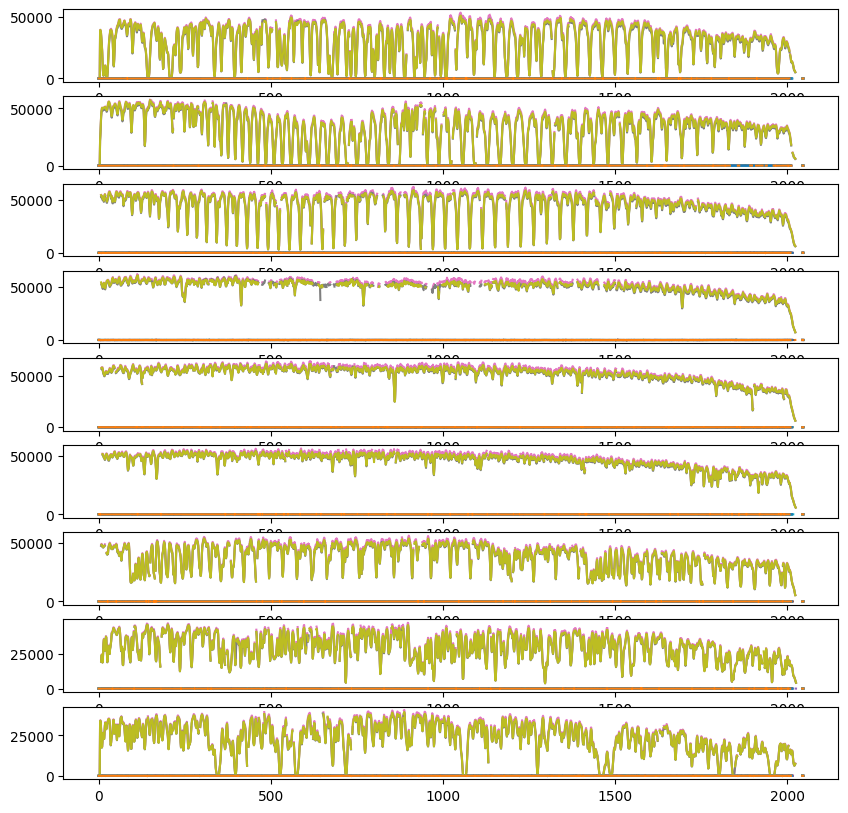

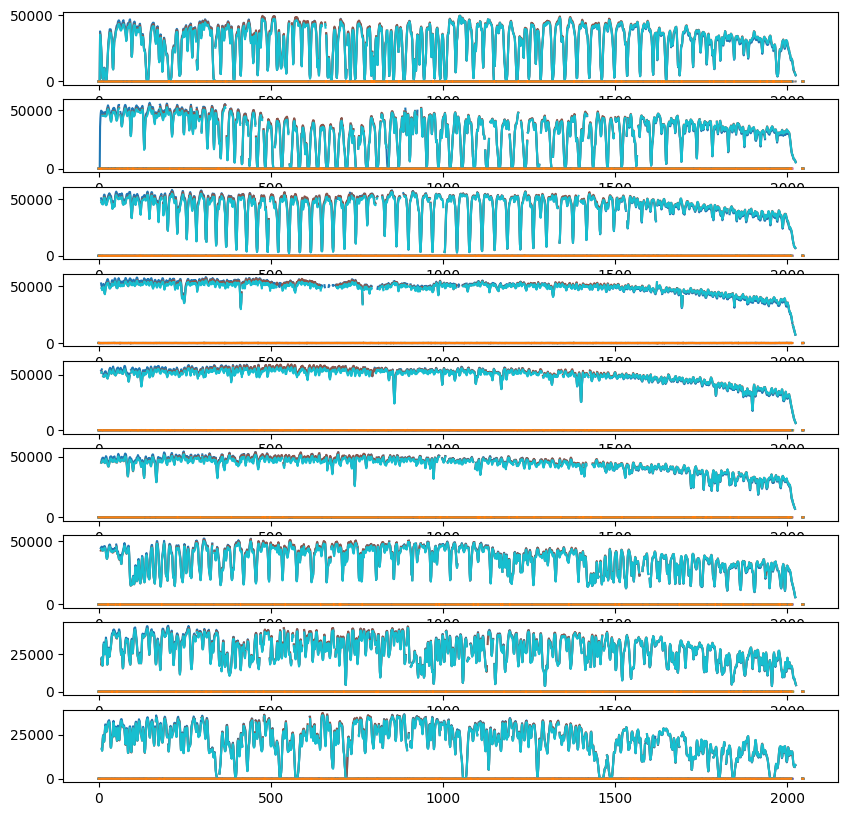

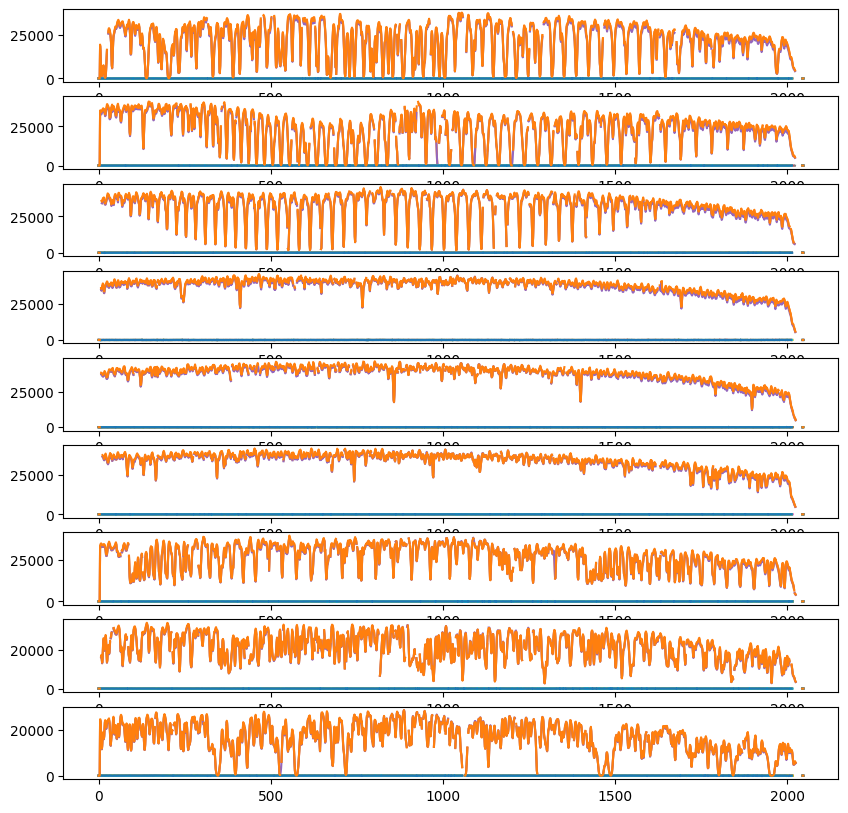

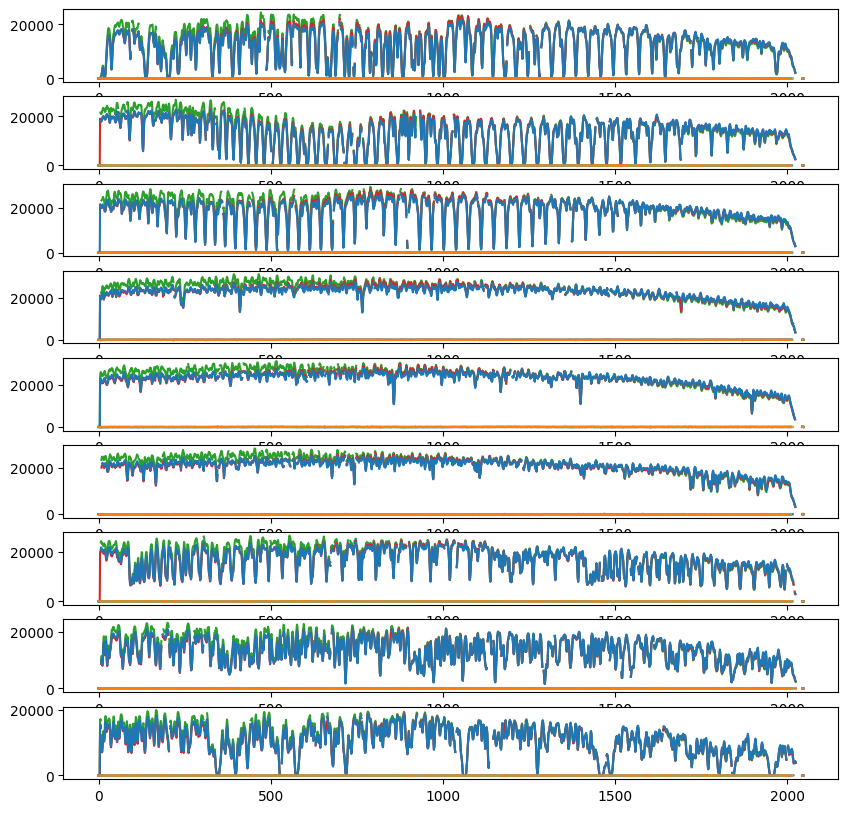

In [18]:
for filename in filelist:
    out_filename = os.path.join(out_flux_dir, os.path.basename(filename).replace(".fits", "_bkgdsub_spectra.fits"))
    this_spectrum = data.Spectrum(filepath=out_filename)
    spec = this_spectrum.fluxes
    err = this_spectrum.errs
    for fib_id in trace_dat.get_sci_indices():
        fig = plt.figure(fib_id + 1, figsize=(10, 10))
        for order_id in range(spec.shape[1]):
            plt.subplot(spec.shape[1], 1, order_id + 1)
            xs = np.arange(spec[fib_id, order_id, :].shape[0])
            plt.plot(xs, spec[fib_id, order_id, :], label=os.path.basename(filename).replace(".fits", ""))
plt.savefig("flux_extraction_star.pdf")
plt.show()



#### Step 5: Wavelength Calibration for  HIP95771 (which is an M0 type star, so I think this is what I need)
$\textbf{Goal}$: Use wavecal_demo.py

In [19]:
import os
import multiprocessing as mp
from glob import glob
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import kpicdrp.wavecal as wavecal
import kpicdrp.utils as utils
import kpicdrp.data as data
from kpicdrp.caldb import trace_caldb, wave_caldb
import pandas as pd
from scipy.interpolate import interp1d


In [20]:
kpicpublicdir = "IRXS/HIP95771/" # main data directory

## Path relative to the public kpic directory
filelist_spectra = glob(os.path.join(kpicpublicdir,"fluxes", "*bkgdsub_spectra.fits")) #this is to glob together all the files in that directory
#print(filelist_spectra) #checking that is work3d

In [30]:
#filename_oldwvs = os.path.join(kpicpublicdir, "utils", "first_guess_wvs_20200928_HIP_81497.fits")
filename_oldwvs = os.path.join(kpicpublicdir, "utils", "211120_HIP_095771_psg_wvs.fits")
#print(filename_oldwvs)
filename_phoenix_rvstandard = os.path.join(kpicpublicdir, "utils", "HIP_81497_lte03600-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
# print(filename_phoenix_rvstandard)
filename_phoenix_wvs =os.path.join(kpicpublicdir, "utils", "WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")
# print(filename_phoenix_wvs)
use_atran = False # Use atran model for tellurics
filelist_atran = glob(os.path.join(kpicpublicdir, "utils","atran","atran_13599_30_*.dat"))
use_psg = True # Use psg model for tellurics
psg_filename = os.path.join(kpicpublicdir,"utils","psg",'psg_out_2020.12.18_l0_1900nm_l1_2600nm_lon_204.53_lat_19.82_pres_0.5826.fits')

In [45]:
"/Users/phillips.1622/Dropbox/KPIC_Work/IRXS/20211022/"

'/Users/phillips.1622/Dropbox/KPIC_Work/IRXS/20211022/'

In [31]:
# define output directory
if use_psg:
    out_filename = os.path.join(kpicpublicdir, "20211022_HIP_95771", "calib", "20211022_HIP_95771_psg_wvs.fits")
if use_atran:
    out_filename = os.path.join(kpicpublicdir, "20211022_HIP_95771", "calib", "20211022_HIP_95771_atran_wvs.fits")
if not os.path.exists(os.path.join(kpicpublicdir, "20211022_HIP_95771", "calib")):
    os.makedirs(os.path.join(kpicpublicdir, "20211022_HIP_95771", "calib"))

In [47]:
# wavelength solution parameters
target_rv = -85.391 # HIP_95771: -85.391km/s ; HIP_81497: -55.567 #km/s
N_nodes_wvs=6 # Number of spline nodes for the wavelength solution
blaze_chunks=5 # Number of chunks of the "blaze profile" (modeled as a piecewise linear function)
init_grid_search = True # do a rough grid search of the wavcal before running optimizer
# init_grid_dwv = 1e-4#3e-4 #microns, how far to go for the grid search. Caution: It can take quite a while!
init_grid_dwv = 4e-4 #3e-4 #microns, how far to go for the grid search. Caution: It can take quite a while! #this is the edit for Jerry 11/30/22

fringing = False
numthreads = 2
mypool = mp.Pool(processes=numthreads)
# mypool = Non

In [48]:
#  Read an old wavelength array to be used as the first guess
# hdulist = fits.open(filename_oldwvs)
# old_wvs = hdulist[0].data
old_wvsoln = data.Wavecal(filepath=filename_oldwvs)

spectral_dataset = data.Dataset(filelist=filelist_spectra, dtype=data.Spectrum)

trace_dat = trace_caldb.get_calib(spectral_dataset[0])

# combine spectral dataset together to a single specrum per fiber
combined_spectrum = utils.stellar_spectra_from_files(spectral_dataset)

In [49]:
# Read the Phoenix model and wavelength corresponding to the RV standard star.
with fits.open(filename_phoenix_wvs) as hdulist:
    phoenix_wvs = hdulist[0].data / 1.e4
crop_phoenix = np.where((phoenix_wvs > 1.8 - (2.6 - 1.8) / 2) * (phoenix_wvs < 2.6 + (2.6 - 1.8) / 2))
phoenix_wvs = phoenix_wvs[crop_phoenix]
with fits.open(filename_phoenix_rvstandard) as hdulist:
    phoenix_spec = hdulist[0].data[crop_phoenix]

In [50]:
new_wvs_arr = np.zeros(combined_spectrum.data.shape)
line_width_func_list = utils.linewidth2func(trace_dat.widths[trace_dat.get_sci_indices()], old_wvsoln.wvs)

/var/folders/q2/w8lwsqgj6gd5ctf_8248mphm0000gn/T/ipykernel_12346/1016244203.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  phoenix_line_widths = np.array(pd.DataFrame(line_width_func_list[fib](phoenix_wvs)).interpolate(method="linear").fillna(method="bfill").fillna(method="ffill"))[:, 0]


broaden Phoenix model
start fitting
[[1.94118680e+00 1.94844918e+00 1.95591855e+00 1.96357267e+00
  1.97133423e+00 1.97921296e+00 5.31055539e-02 1.12673532e+00]
 [1.99176304e+00 1.99923130e+00 2.00692569e+00 2.01480644e+00
  2.02279510e+00 2.03091355e+00 7.34473140e-08 1.18481225e+00]
 [2.04510678e+00 2.05277631e+00 2.06069937e+00 2.06881582e+00
  2.07705511e+00 2.08538283e+00 2.49169257e-02 1.02883712e+00]
 [2.10139468e+00 2.10932569e+00 2.11748231e+00 2.12584253e+00
  2.13431709e+00 2.14298659e+00 3.35156225e-01 3.84774189e-01]
 [2.16109054e+00 2.16912914e+00 2.17754306e+00 2.18614445e+00
  2.19488705e+00 2.20374423e+00 7.97018766e-07 7.07590817e-01]
 [2.22409313e+00 2.23251610e+00 2.24116381e+00 2.25004952e+00
  2.25903897e+00 2.26815750e+00 7.67197437e-06 7.80514460e-01]
 [2.29110886e+00 2.29976763e+00 2.30868754e+00 2.31783403e+00
  2.32710016e+00 2.33648861e+00 1.50414811e-06 8.54196724e-01]
 [2.36237710e+00 2.37130098e+00 2.38048537e+00 2.38990567e+00
  2.39945320e+00 2.40911708

/var/folders/q2/w8lwsqgj6gd5ctf_8248mphm0000gn/T/ipykernel_12346/1016244203.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  phoenix_line_widths = np.array(pd.DataFrame(line_width_func_list[fib](phoenix_wvs)).interpolate(method="linear").fillna(method="bfill").fillna(method="ffill"))[:, 0]


broaden Phoenix model
start fitting
[[1.94122407e+00 1.94848375e+00 1.95595136e+00 1.96360526e+00
  1.97135805e+00 1.97923432e+00 6.34853955e-02 1.12833444e+00]
 [1.99180451e+00 1.99926198e+00 2.00695145e+00 2.01482974e+00
  2.02282092e+00 2.03089554e+00 7.80585186e-08 1.17266858e+00]
 [2.04514898e+00 2.05280439e+00 2.06072451e+00 2.06884002e+00
  2.07707507e+00 2.08540475e+00 2.53273274e-05 1.02313256e+00]
 [2.10141725e+00 2.10934476e+00 2.11750854e+00 2.12587228e+00
  2.13433031e+00 2.14301254e+00 8.56280941e-01 3.75460855e-04]
 [2.16097049e+00 2.16916453e+00 2.17755692e+00 2.18616587e+00
  2.19495003e+00 2.20405032e+00 2.10087922e-01 5.47021075e-01]
 [2.22412672e+00 2.23252425e+00 2.24117659e+00 2.25005239e+00
  2.25905808e+00 2.26815267e+00 3.26068257e-04 7.47700867e-01]
 [2.29113388e+00 2.29977425e+00 2.30869914e+00 2.31783860e+00
  2.32711208e+00 2.33649740e+00 5.82524905e-06 8.08119813e-01]
 [2.36237707e+00 2.37130573e+00 2.38049116e+00 2.38991253e+00
  2.39945867e+00 2.40912963

/var/folders/q2/w8lwsqgj6gd5ctf_8248mphm0000gn/T/ipykernel_12346/1016244203.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  phoenix_line_widths = np.array(pd.DataFrame(line_width_func_list[fib](phoenix_wvs)).interpolate(method="linear").fillna(method="bfill").fillna(method="ffill"))[:, 0]


broaden Phoenix model
start fitting
[[1.94127257e+00 1.94853384e+00 1.95599515e+00 1.96364514e+00
  1.97139650e+00 1.97927151e+00 8.00778441e-02 1.17780529e+00]
 [1.99151928e+00 1.99891698e+00 2.00640297e+00 2.01415784e+00
  2.02202867e+00 2.03099231e+00 4.00635995e-08 9.15776099e-01]
 [2.04473681e+00 2.05228092e+00 2.06009928e+00 2.06812954e+00
  2.07635592e+00 2.08540470e+00 1.73354040e+00 9.84154352e-01]
 [2.10145441e+00 2.10938160e+00 2.11754306e+00 2.12590039e+00
  2.13437135e+00 2.14303575e+00 5.17960757e-01 3.46704956e-01]
 [2.16131270e+00 2.16919477e+00 2.17758825e+00 2.18620273e+00
  2.19494024e+00 2.20377965e+00 3.85689019e-07 8.28287966e-01]
 [2.22414159e+00 2.23255710e+00 2.24120716e+00 2.25009365e+00
  2.25908254e+00 2.26820167e+00 1.06307901e-01 8.59677141e-01]
 [2.29115135e+00 2.29980075e+00 2.30872232e+00 2.31786325e+00
  2.32713753e+00 2.33652426e+00 1.64821978e-02 8.07015483e-01]
 [2.36239875e+00 2.37132367e+00 2.38051099e+00 2.38993313e+00
  2.39948147e+00 2.40915054

/var/folders/q2/w8lwsqgj6gd5ctf_8248mphm0000gn/T/ipykernel_12346/1016244203.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  phoenix_line_widths = np.array(pd.DataFrame(line_width_func_list[fib](phoenix_wvs)).interpolate(method="linear").fillna(method="bfill").fillna(method="ffill"))[:, 0]


broaden Phoenix model
start fitting
[[1.94130163e+00 1.94855485e+00 1.95601676e+00 1.96366267e+00
  1.97141427e+00 1.97926781e+00 5.76633536e-02 1.25336901e+00]
 [1.99175252e+00 1.99893798e+00 2.00643355e+00 2.01416877e+00
  2.02204763e+00 2.03086506e+00 1.81467336e-09 9.42985504e-01]
 [2.04475306e+00 2.05229870e+00 2.06011446e+00 2.06814298e+00
  2.07631975e+00 2.08513065e+00 2.96570064e-04 1.05328849e+00]
 [2.10147091e+00 2.10939255e+00 2.11755157e+00 2.12591414e+00
  2.13437131e+00 2.14316748e+00 4.81905383e-01 5.16673980e-01]
 [2.16100169e+00 2.16921043e+00 2.17759495e+00 2.18620843e+00
  2.19493731e+00 2.20379915e+00 1.15949371e-01 9.12826414e-01]
 [2.22416744e+00 2.23254613e+00 2.24120586e+00 2.25009325e+00
  2.25908285e+00 2.26819881e+00 1.19071844e-04 8.88182297e-01]
 [2.29115573e+00 2.29979337e+00 2.30872026e+00 2.31786044e+00
  2.32713432e+00 2.33652030e+00 2.97309189e-04 8.90065843e-01]
 [2.36239392e+00 2.37130927e+00 2.38049858e+00 2.38992444e+00
  2.39947474e+00 2.40914234

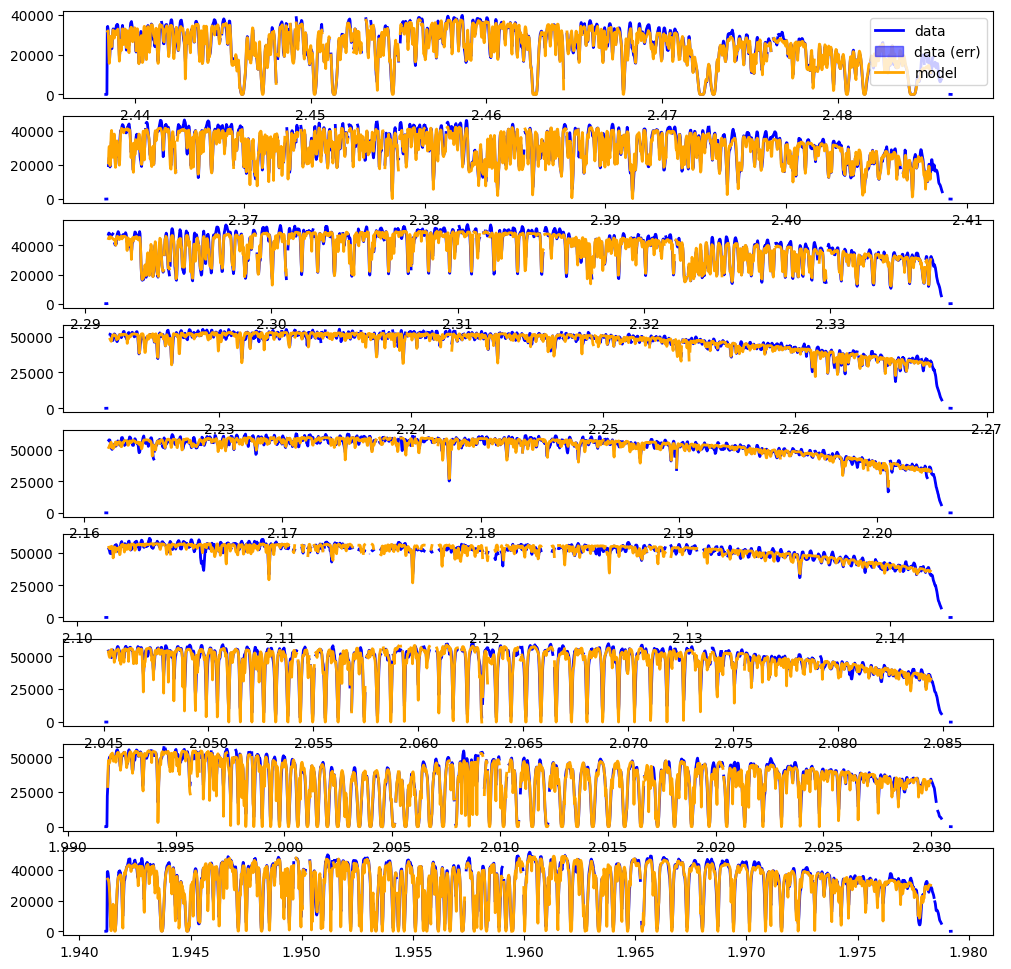

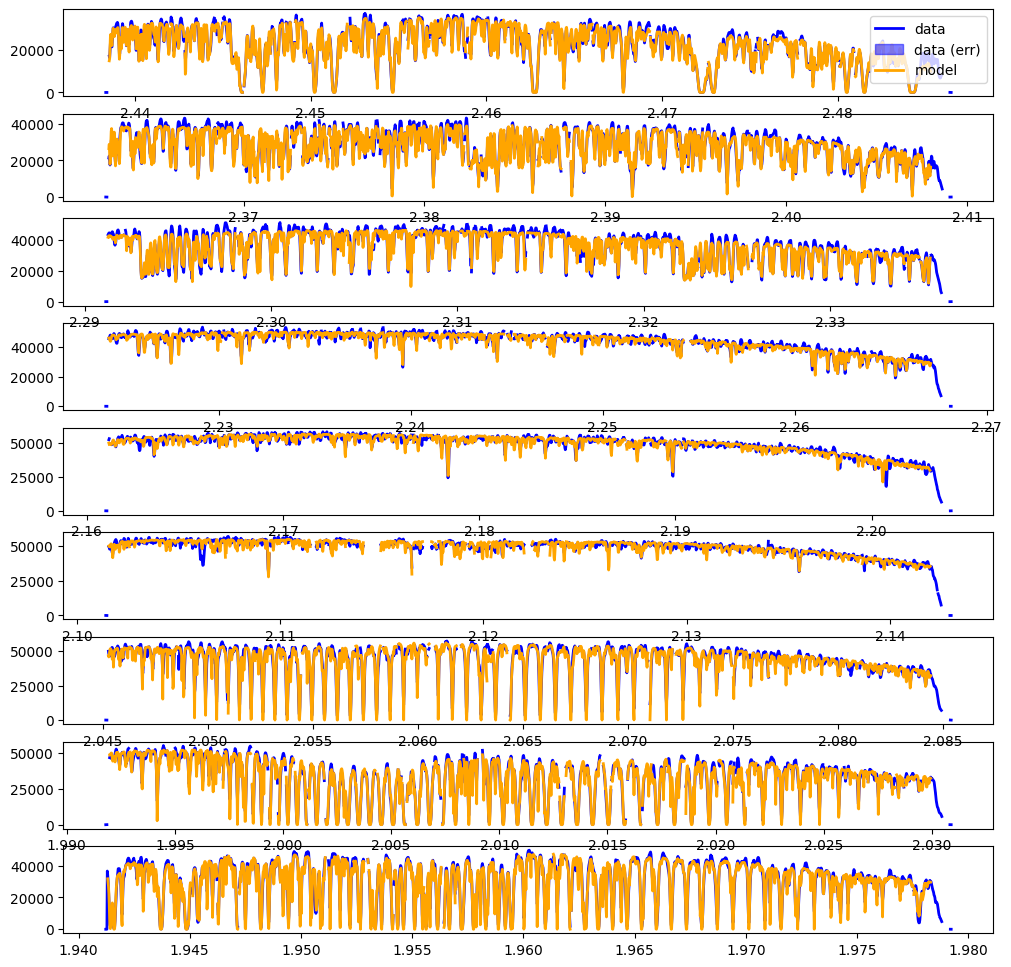

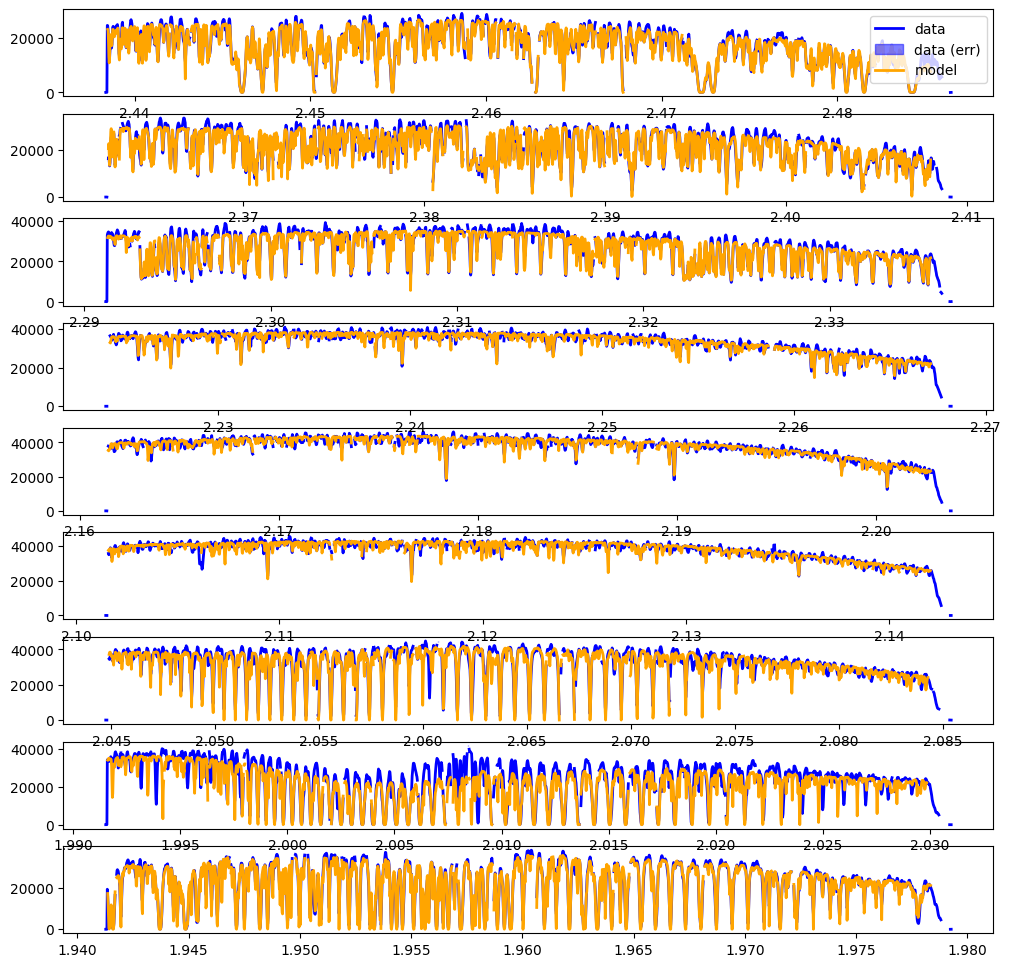

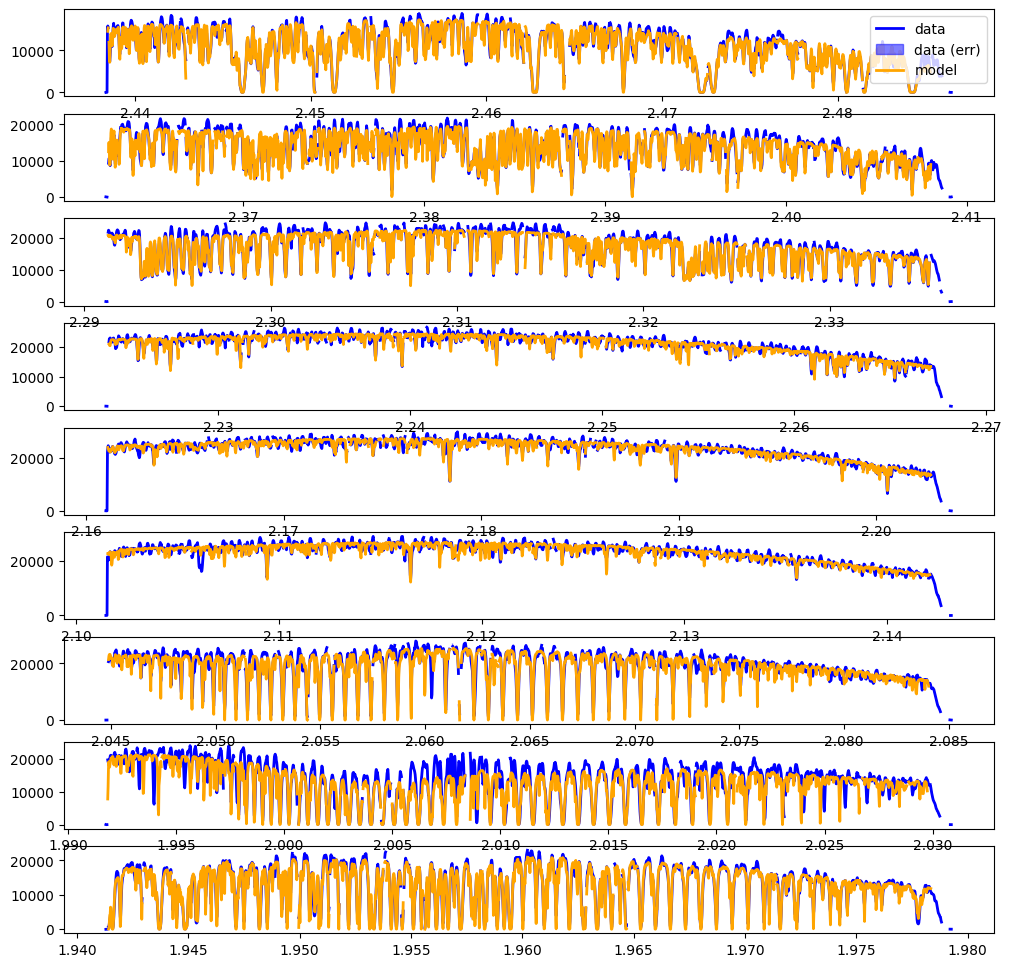

In [51]:
fib_labels = []
for fib in range(combined_spectrum.fluxes.shape[0]):
    if np.nansum(combined_spectrum.fluxes[fib,:,:])==0:
        continue
    baryrv_fib = combined_spectrum.header['BARYRV{0}'.format(fib)]
    star_rv = target_rv - baryrv_fib

    # broaden and create interpolation function for the Phoenix model
    phoenix_line_widths = np.array(pd.DataFrame(line_width_func_list[fib](phoenix_wvs)).interpolate(method="linear").fillna(method="bfill").fillna(method="ffill"))[:, 0]
    print("broaden Phoenix model")
    phoenix_conv = utils.convolve_spectrum_line_width(phoenix_wvs, phoenix_spec, phoenix_line_widths, mypool=mypool)
    ##
    phoenix_func = interp1d(phoenix_wvs, phoenix_conv / np.nanmax(phoenix_conv), bounds_error=False,fill_value=np.nan)

    if use_atran: #atran
        ## Create a interpolation function for the tellurics model (including water and zenith angle)
        atrangridname = os.path.join(kpicpublicdir, "utils","atran", "atran_grid_f{0}.fits".format(fib))
        if 0:
            # enable this section to broaden and save the atran grid of models.
            # The resulting fits file can directly be used to generate a regular grid interpolator as shown below.
            # the broadening is specific to the line width calibration, so it might vary from epoch to epoch and maybe
            # even between fibers. That being said, it might not make a big difference...
            wavecal.save_atrangrid(filelist_atran, line_width_func_list[fib], atrangridname,mypool=mypool)
            # exit()
        hdulist = fits.open(atrangridname)
        atran_grid =  hdulist[0].data
        water_unique =  hdulist[1].data
        angle_unique =  hdulist[2].data
        atran_wvs =  hdulist[3].data
        hdulist.close()
        ##
        print("atran grid interpolator")
        atran_interpgrid = RegularGridInterpolator((water_unique,angle_unique),atran_grid,method="linear",bounds_error=False,fill_value=0.0)

        # Derive wavecal for a single fiber
        print("start fitting")
        new_wvs_fib,model,out_paras = wavecal.fit_wavecal_fib(old_wvsoln.wvs[fib,:,:], combined_spectrum.fluxes[fib,:,:], combined_spectrum.errs[fib,:,:],
                                                        phoenix_func,star_rv,atran_wvs,atran_interpgrid,
                                                        N_nodes_wvs=N_nodes_wvs,
                                                        blaze_chunks=blaze_chunks,
                                                        init_grid_search = init_grid_search,
                                                        init_grid_dwv = init_grid_dwv,
                                                        fringing=fringing,
                                                        mypool=mypool)
    if use_psg:
        # define things for example
        l0, l1   = 1900,2600 # bounds to compute the telluric model in nm

        wvs_psg, psg_tuple = wavecal.open_psg_allmol(psg_filename,l0,l1) # return x array and psg spectra returned in a tuple
        wvs_psg /= 1000 # convert from nm to um

        # Derive wavecal for a single fiber
        print("start fitting")
        new_wvs_fib,model,out_paras = wavecal.fit_psg_wavecal_fib(old_wvsoln.wvs[fib,:,:], combined_spectrum.fluxes[fib,:,:], combined_spectrum.errs[fib,:,:],
                                                        phoenix_func,star_rv,wvs_psg,psg_tuple,
                                                        N_nodes_wvs=N_nodes_wvs,
                                                        blaze_chunks=blaze_chunks,
                                                        init_grid_search = init_grid_search,
                                                        init_grid_dwv = init_grid_dwv,
                                                        fringing=fringing,
                                                        mypool=mypool)
        print(out_paras)

    new_wvs_arr[fib,:,:] = new_wvs_fib
    fib_labels.append(combined_spectrum.labels[fib])

    plt.figure(fib+1,figsize=(12,12))
    ax_list = utils.plot_kpic_spectrum(combined_spectrum.fluxes[fib,:,:] ,wvs=new_wvs_fib, arr_err=combined_spectrum.errs[fib,:,:],color="blue",label="data")
    ax_list = utils.plot_kpic_spectrum(model,wvs=new_wvs_fib,color="orange",label="model",ax_list=ax_list)
    plt.legend()
    print("Saving " + out_filename.replace(".fits","_f{0}.png".format(fib)))
    plt.savefig(out_filename.replace(".fits","_f{0}.png".format(fib)))
    # plt.show()

In [52]:
new_wvs = data.Wavecal(wvs=new_wvs_arr, header=combined_spectrum.header, labels=fib_labels, method="Star", filepath=out_filename)
new_wvs.save(caldb=wave_caldb)

plt.show()


# Note the above steps where for RV Calibrator - IRXS
# Below we want to extract the flux for the Host Star and the Companion


## For the Host Star - IRXS

In [21]:
# We will extract the flux for our RV calibrator, but in general this can be for anything say IRXS - I'm doing this for

# load in the files we generated in the background_demo.py example
# or we can load in the backup calibrations in the example data
# you can replace with your own generated backgrounds if you would like

In [22]:
mypool = mp.Pool(2)
# Public KPIC google drive
kpicpublicdir = "IRXS/Host/" # main data dir for the companion
raw_data_dir = os.path.join(kpicpublicdir, "raw") # raw 2D images for IRXS B Companion
out_flux_dir = os.path.join(kpicpublicdir,"20211022_IRXS", "fluxes")

In [23]:
if not os.path.exists(os.path.join(out_flux_dir)):
    os.makedirs(os.path.join(out_flux_dir))
filelist = glob(os.path.join(raw_data_dir, "*.fits"))

In [11]:
# get background traces if they aren't there already
if 'b1' not in trace_dat.labels:
    trace_dat = trace.get_background_traces(trace_dat)

NameError: name 'trace_dat' is not defined

In [24]:
trace_dat = trace_caldb.get_calib(raw_sci_dataset[0])
raw_sci_dataset = data.Dataset(filelist=filelist, dtype=data.DetectorFrame)
# fetch calibration files
bkgd = det_caldb.get_calib(raw_sci_dataset[0], type="Background")
badpixmap = det_caldb.get_calib(raw_sci_dataset[0], type="BadPixelMap")

In [60]:
sci_dataset = extraction.process_sci_raw2d(raw_sci_dataset, bkgd, badpixmap, detect_cosmics=True, add_baryrv=True,nod_subtraction='nod')

/Users/emac/kpic_pipeline/kpicdrp/extraction.py:71: RuntimeWarning: invalid value encountered in sqrt
  noise_e = np.sqrt(var_e)
/Users/emac/kpic_pipeline/kpicdrp/extraction.py:235: RuntimeWarning: Mean of empty slice
  bkgd = np.nanmean(raw_frames[good_frames].get_dataset_attributes('data'), axis=0)
/Users/emac/kpic_pipeline/kpicdrp/extraction.py:236: RuntimeWarning: Mean of empty slice
  bkgd_noise = np.nanmean(raw_frames[good_frames].get_dataset_attributes('noise'), axis=0)/np.sqrt(np.size(good_frames))


In [61]:
spectral_dataset = extraction.extract_flux(sci_dataset, trace_dat, fit_background=True, bad_pixel_fraction=0.01, pool=mypool)

spectral_dataset.save(filedir=out_flux_dir)

/Users/emac/kpic_pipeline/kpicdrp/extraction.py:426: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_emperical = np.sqrt(gain*flux + (bkgd_noise * np.sqrt(2*np.pi) * sigma)**2 )
/Users/emac/kpic_pipeline/kpicdrp/extraction.py:426: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_emperical = np.sqrt(gain*flux + (bkgd_noise * np.sqrt(2*np.pi) * sigma)**2 )


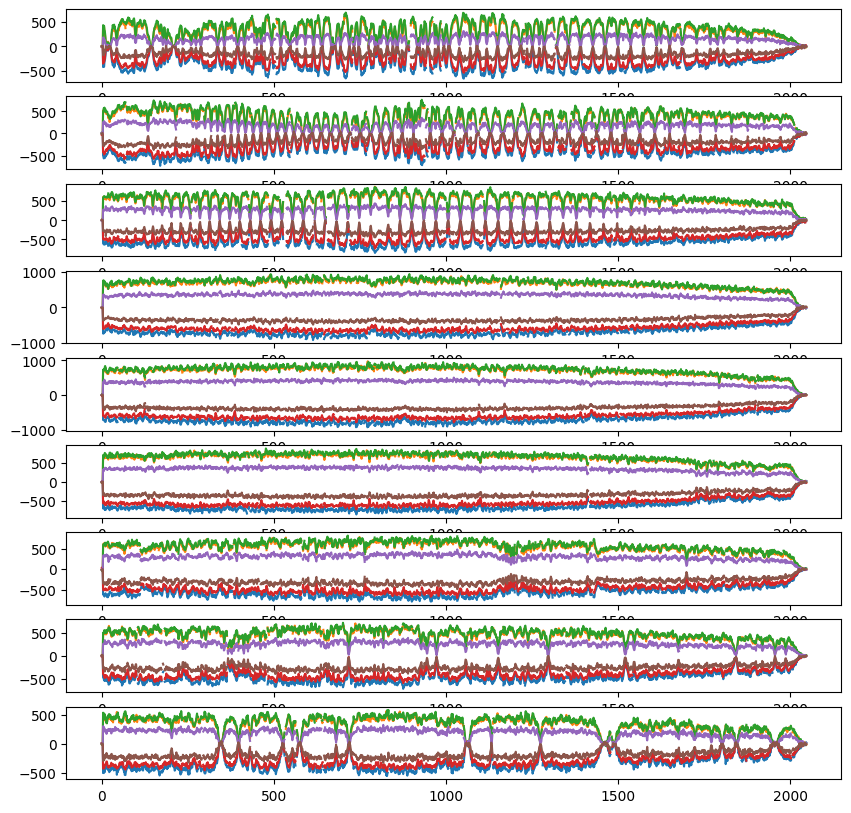

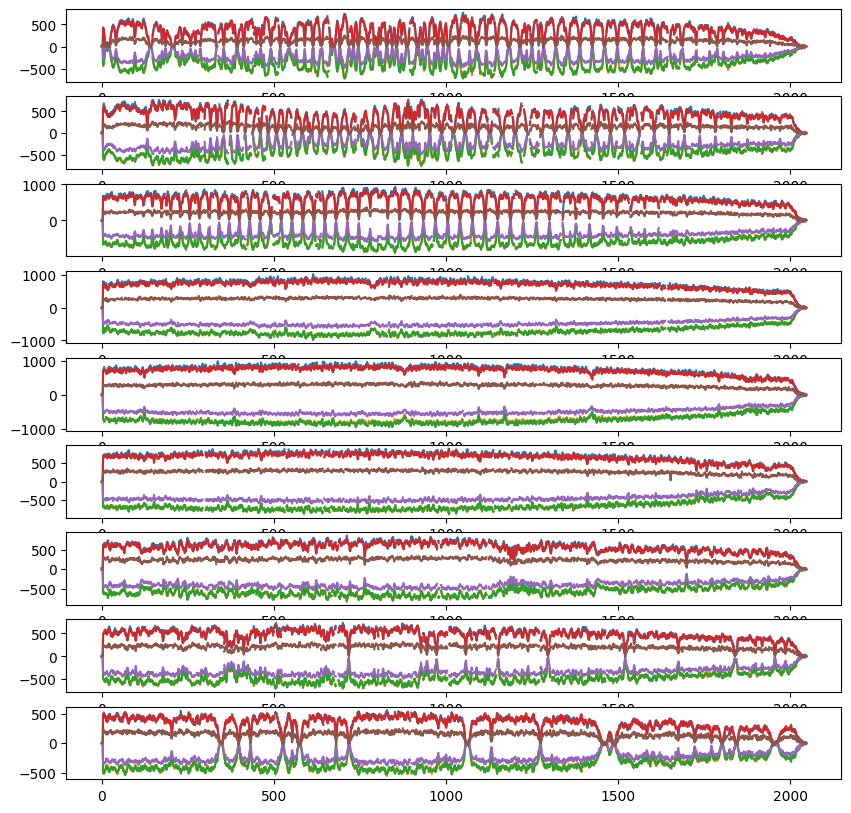

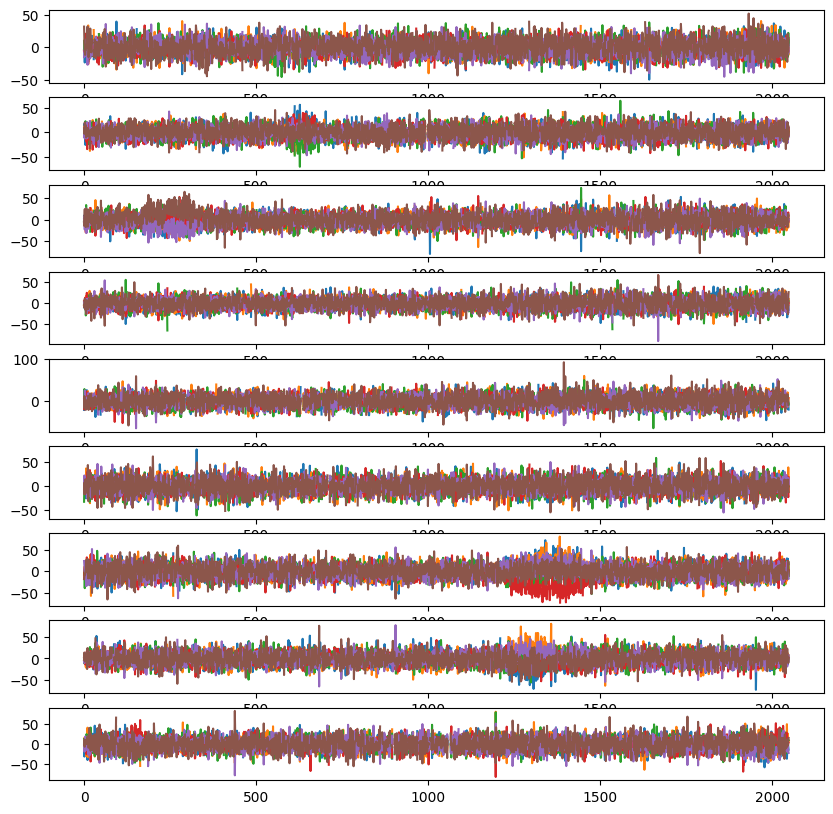

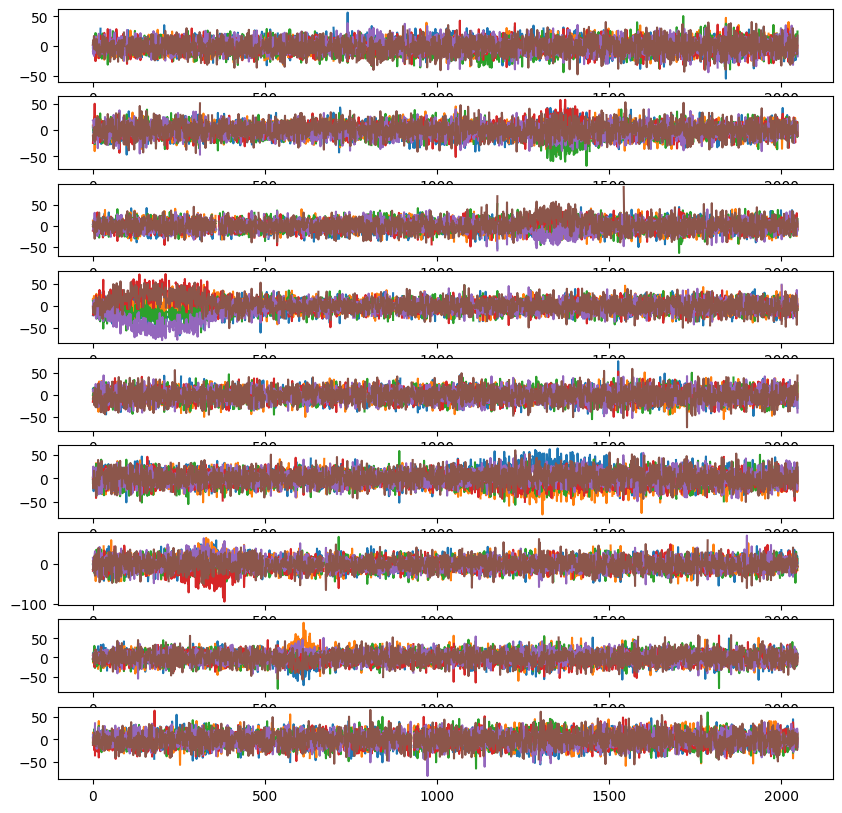

In [62]:
for filename in filelist:
    out_filename = os.path.join(out_flux_dir, os.path.basename(filename).replace(".fits", "_nodsub_spectra.fits"))
#     out_filename = os.path.join(out_flux_dir, os.path.basename(filename).replace(".fits", "_fluxes.fits"))

    this_spectrum = data.Spectrum(filepath=out_filename)
    spec = this_spectrum.fluxes
    err = this_spectrum.errs
    for fib_id in trace_dat.get_sci_indices():
        fig = plt.figure(fib_id + 1, figsize=(10, 10))
        for order_id in range(spec.shape[1]):
            plt.subplot(spec.shape[1], 1, order_id + 1)
            xs = np.arange(spec[fib_id, order_id, :].shape[0])
            plt.plot(xs, spec[fib_id, order_id, :], label=os.path.basename(filename).replace(".fits", ""))
# plt.savefig("flux_extraction_companion.pdf")
plt.show()

 ## For the Companion - IRXSB
This is what Jason said on Slack:

$\textbf{Jason:}$ you can copy the extraction demo, and apply it to the companion. The only thing to change are the filenumbers and that you'll want to use the nod_subtraction='nod' keyword in process_sci_raw2d() function. This does nod subtraction to remove the thermal background of the instrument. You'll then be able to get 1d spectra of the companion, which you can then do cross-correlation or fitting on

$\textbf{Jason:}$ Yes, and if you already reduced the master backgroudns, bad pixel maps, trace plots from the same night already, you don't have to do them again. you just do the extraction of the companion files.

In [25]:
import numpy as np
import astropy.io.fits as fits
import astropy.io.ascii as ascii
import astropy.table as table
import scipy.ndimage as ndi
import os
import multiprocessing as mp
from glob import glob
import kpicdrp.utils as utils
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import kpicdrp.trace as trace
import kpicdrp.extraction as extraction
import kpicdrp.data as data
from kpicdrp.caldb import det_caldb, trace_caldb

In [26]:
# We will extract the flux for our RV calibrator, but in general this can be for anything say IRXSB

# load in the files we generated in the background_demo.py example
# or we can load in the backup calibrations in the example data
# you can replace with your own generated backgrounds if you would like

In [27]:
mypool = mp.Pool(2)

# Public KPIC google drive
kpicpublicdir = "IRXS/Companion/" # main data dir for the companion
raw_data_dir = os.path.join(kpicpublicdir, "raw") # raw 2D images for IRXS B Companion
out_flux_dir = os.path.join(kpicpublicdir,"20211022_IRXSB", "fluxes")

In [35]:
if not os.path.exists(os.path.join(out_flux_dir)):
    os.makedirs(os.path.join(out_flux_dir))
filelist = glob(os.path.join(raw_data_dir, "*.fits"))

In [36]:
# get background traces if they aren't there already
if 'b1' not in trace_dat.labels:
    trace_dat = trace.get_background_traces(trace_dat)

In [28]:
trace_dat = trace_caldb.get_calib(raw_sci_dataset[0])
raw_sci_dataset = data.Dataset(filelist=filelist, dtype=data.DetectorFrame)

In [38]:
# fetch calibration files
bkgd = det_caldb.get_calib(raw_sci_dataset[0], type="Background")
badpixmap = det_caldb.get_calib(raw_sci_dataset[0], type="BadPixelMap")

In [39]:
sci_dataset = extraction.process_sci_raw2d(raw_sci_dataset, bkgd, badpixmap, detect_cosmics=True, add_baryrv=True,nod_subtraction='nod')

/Users/emac/kpic_pipeline/kpicdrp/extraction.py:71: RuntimeWarning: invalid value encountered in sqrt
  noise_e = np.sqrt(var_e)
Process SpawnPoolWorker-7:
Process SpawnPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/emac/anaconda3/envs/KPIC_DRP_NEW/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/emac/anaconda3/envs/KPIC_DRP_NEW/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/emac/anaconda3/envs/KPIC_DRP_NEW/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/emac/anaconda3/envs/KPIC_DRP_NEW/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/emac/anaconda3/envs/KPIC_DRP_NEW/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [71]:
spectral_dataset = extraction.extract_flux(sci_dataset, trace_dat, fit_background=True, bad_pixel_fraction=0.01, pool=mypool)

spectral_dataset.save(filedir=out_flux_dir)

/Users/emac/kpic_pipeline/kpicdrp/extraction.py:426: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_emperical = np.sqrt(gain*flux + (bkgd_noise * np.sqrt(2*np.pi) * sigma)**2 )
/Users/emac/kpic_pipeline/kpicdrp/extraction.py:426: RuntimeWarning: invalid value encountered in sqrt
  fluxerr_emperical = np.sqrt(gain*flux + (bkgd_noise * np.sqrt(2*np.pi) * sigma)**2 )
/Users/emac/anaconda3/envs/KPIC_DRP_NEW/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/emac/kpic_pipeline/kpicdrp/extraction.py:383: RuntimeWarning: All-NaN slice encountered
  bkgd_level = np.nanmedian(bkgd_slice)


In [32]:
#spectral_dataset.save(filedir=out_flux_dir)
print(filelist)
filename = 'IRXS/Companion/raw/nspec211022_1210.fits'

['IRXS/Host/raw/nspec211022_1210.fits', 'IRXS/Host/raw/nspec211022_1211.fits', 'IRXS/Host/raw/nspec211022_1216.fits', 'IRXS/Host/raw/nspec211022_1217.fits', 'IRXS/Host/raw/nspec211022_1204.fits', 'IRXS/Host/raw/nspec211022_1205.fits']


In [33]:
max(xs)

np.int64(2047)

In [99]:
sf2_wvs.shape[0]

9

In [34]:

#out_filename = os.path.join(out_flux_dir, os.path.basename(filename).replace(".fits", "_nodsub_spectra.fits"))
#     out_filename = os.path.join(out_flux_dir, os.path.basename(filename).replace(".fits", "_fluxes.fits"))

this_spectrum = data.Spectrum(filepath=out_filename)
spec = this_spectrum.fluxes
err = this_spectrum.errs
plt.figure(figsize = (29, 6))
plt.plot(sf2_wvs[0], spec[trace_dat.get_sci_indices()[0], 0, :], label='spectrum')
plt.plot(sf2_wvs[0], (err[trace_dat.get_sci_indices()[0], 0, :]), label='error')

plt.legend()
# plt.savefig("flux_extraction_companion.pdf")
plt.show()

NameError: name 'sf2_wvs' is not defined

<Figure size 2900x600 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (1,) and (2048,)

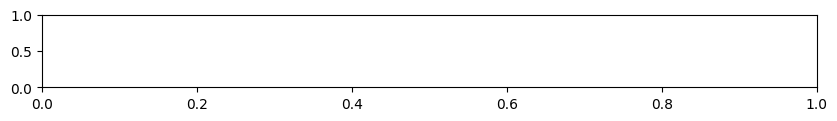

In [101]:

out_filename = os.path.join(out_flux_dir, os.path.basename(filename).replace(".fits", "_nodsub_spectra.fits"))
#     out_filename = os.path.join(out_flux_dir, os.path.basename(filename).replace(".fits", "_fluxes.fits"))

this_spectrum = data.Spectrum(filepath=out_filename)
spec = this_spectrum.fluxes
err = this_spectrum.errs
for x in range(sf2_wvs.shape[0]):
    for fib_id in trace_dat.get_sci_indices():
        fig = plt.figure(fib_id + 1, figsize=(10, 10))
        for order_id in range(spec.shape[1]):
            plt.subplot(spec.shape[1], 1, order_id + 1)
            plt.plot(x, spec[fib_id, order_id, :], label=os.path.basename(filename).replace(".fits", ""))
            
            #plt.legend()
# plt.savefig("flux_extraction_companion.pdf")
plt.show()

In [105]:
for filename in filelist:
    out_filename = os.path.join(out_flux_dir, os.path.basename(filename).replace(".fits", "_nodsub_spectra.fits"))
#     out_filename = os.path.join(out_flux_dir, os.path.basename(filename).replace(".fits", "_fluxes.fits"))

    this_spectrum = data.Spectrum(filepath=out_filename)
    spec = this_spectrum.fluxes
    err = this_spectrum.errs
    for fib_id in trace_dat.get_sci_indices():
        fig = plt.figure(fib_id + 1, figsize=(10, 10))
        for order_id in range(spec.shape[1]):
            plt.subplot(spec.shape[1], 1, order_id + 1)
            xs = np.arange(spec[fib_id, order_id, :].shape[0])
            plt.plot(xs, spec[fib_id, order_id, :], label=os.path.basename(filename).replace(".fits", ""))
            plt.legend()
# plt.savefig("flux_extraction_companion.pdf")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'IRXS/Companion/20211022_IRXSB/fluxes/nspec200928_01206_nodsub_spectra.fits'

# So I think the next step is cross correlation using xcorr_demo.py

In [76]:
"""
X-Corr 1RXSB
"""
import numpy as np
import astropy.io.fits as fits
import astropy.io.ascii as ascii
import astropy.table as table
import scipy.ndimage as ndi
import os
import multiprocessing as mp
import astropy.units as u

import matplotlib.pylab as plt

import kpicdrp.extraction
import kpicdrp.xcorr as xcorr

In [77]:
# Run the extraction code on the planet data
main_dir = "IRXS/Companion/" # main data dir
target_dir = os.path.join(main_dir,"20211022_IRXSB") # the planet of interest
# calib_dir = os.path.join(target_dir, "calib") # calib subdir
calib_dir = os.path.join("IRXS/HIP95771/20211022_HIP_95771/calib/")
raw_data_dir = os.path.join(target_dir, "raw") # raw 2D images
print(raw_data_dir)


IRXS/Companion/20211022_IRXSB/raw


In [78]:
# select science files
filestr = "nspec200928_0{0:03d}.fits"
# filenums =  [77, 83]
filenums =  [1206, 1207,1208,1209,1212,1213,1214,1215,1218,1219] #these are all the files for companion
filelist = [os.path.join(raw_data_dir, filestr.format(i)) for i in filenums]
print(filelist)

['IRXS/Companion/20211022_IRXSB/raw/nspec200928_01206.fits', 'IRXS/Companion/20211022_IRXSB/raw/nspec200928_01207.fits', 'IRXS/Companion/20211022_IRXSB/raw/nspec200928_01208.fits', 'IRXS/Companion/20211022_IRXSB/raw/nspec200928_01209.fits', 'IRXS/Companion/20211022_IRXSB/raw/nspec200928_01212.fits', 'IRXS/Companion/20211022_IRXSB/raw/nspec200928_01213.fits', 'IRXS/Companion/20211022_IRXSB/raw/nspec200928_01214.fits', 'IRXS/Companion/20211022_IRXSB/raw/nspec200928_01215.fits', 'IRXS/Companion/20211022_IRXSB/raw/nspec200928_01218.fits', 'IRXS/Companion/20211022_IRXSB/raw/nspec200928_01219.fits']


In [84]:
# load wavelength solution
with fits.open(os.path.join(calib_dir, "20211022_HIP_95771_psg_wvs.fits")) as hdulist:
    all_wvs = np.copy(hdulist[0].data)
    sf2_wvs = all_wvs[1]
    print(len(sf2_wvs[0]))

2048


In [79]:
all_fluxes = []
all_errors = []
for num in filenums:
    filepath = os.path.join(target_dir,"fluxes", "nspec211022_{0:03d}_nodsub_spectra.fits".format(num))
    with fits.open(filepath) as hdulist:
        flux = hdulist[0].data
        err = hdulist[1].data

    all_fluxes.append(flux)
    all_errors.append(err)

all_fluxes = np.array(all_fluxes)
all_errors = np.array(all_errors)

print(np.nanmean(all_fluxes, axis=(1,2)))

[[ 0.91352921 -0.76352121  1.46684685 ... -0.30178654  2.94859452
  -0.31296284]
 [ 0.3282407   1.51184133  0.74374661 ...  2.54365823  0.73724927
   1.17025346]
 [ 2.28515014  0.89207998  1.51675962 ...  1.86556687  0.84992487
   1.70577819]
 ...
 [ 1.97536796  1.99306093  0.9168778  ...  3.75702111  1.36041413
   1.72830629]
 [ 0.46418334  0.8862366   0.8702051  ...  2.05115327  4.45281306
   1.52301291]
 [ 0.82844008  1.13849455  0.82548576 ...  0.44694448  3.39085069
   2.97694657]]


In [80]:

# combine in time
tot_fluxes = np.nansum(all_fluxes, axis=0)
tot_errors = np.sqrt(np.nansum(all_errors**2, axis=0))

sf2_fluxes = tot_fluxes[1]
sf2_fluxes[:,:50] = np.nan
sf2_fluxes[:,-150:] = np.nan

In [81]:
# read in star fluxes
main_dir="IRXS/Host/20211022_IRXS/fluxes/"
star_target_dir = os.path.join(main_dir) # the star of interest
# star_filenums =  [71, 84]
star_filenums =  [1204,1205,1210,1211,1216,1217]

all_star_fluxes = []
all_star_errors = []
for num in star_filenums:
#     filepath = os.path.join(star_target_dir, "nspec211022_{0:03d}.fits".format(num))
    filepath = os.path.join(star_target_dir, "nspec211022_{0:03d}_nodsub_spectra.fits".format(num))

    with fits.open(filepath) as hdulist:
        flux = hdulist[0].data
        err = hdulist[1].data

    all_star_fluxes.append(flux)
    all_star_errors.append(err)

all_star_fluxes = np.array(all_star_fluxes)
all_star_errors = np.array(all_star_errors)

print(np.nanmean(all_star_fluxes, axis=(1,2)))

[[ 2.32277641  0.55304295  0.29483144 ...  0.02137589 -1.26485847
   0.6906037 ]
 [-2.17992149 -1.23024654  1.00136373 ...  0.48338821  0.73149284
   1.04078614]
 [ 1.04568866 -1.53539658 -0.20690028 ...  2.50068007  3.96525402
  -1.24281321]
 [-0.79955126 -0.79915907  0.44753833 ...  1.29438756 -1.96439557
   0.64623343]
 [-2.2053649   4.00882273  1.14408698 ...  0.68008904 -3.79743775
   3.93049166]
 [-1.89260557 -4.04110399 -2.5743194  ... -2.38791466  1.77155893
  -3.74454358]]


In [82]:
# combine in time
tot_star_fluxes = np.nansum(all_star_fluxes, axis=0)
tot_star_errors = np.sqrt(np.nansum(all_star_errors**2, axis=0))

sf2_star_fluxes = tot_star_fluxes[1]

In [83]:
## read in the star model
phoenix_dir = "IRXS/HIP95771/utils/"
hdulist = fits.open(phoenix_dir + "WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")
star_model_wvs = hdulist[0].data
hdulist.close()

hdulist = fits.open(phoenix_dir + "HIP_81497_lte03600-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits", ignore_missing_end=True)
star_model = hdulist[0].data
hdulist.close()

star_radius = hdulist[0].header['PHXREFF'] #cm
star_model_wvs /= 10000

In [84]:
nir = np.where((star_model_wvs >= 0.9) &(star_model_wvs < 5) )
star_model_wvs = star_model_wvs[nir]
star_model = star_model[nir]
star_model_r = np.median(star_model_wvs)/np.median(star_model_wvs - np.roll(star_model_wvs, 1))
star_model_downsample = star_model_r/35000/(2*np.sqrt(2*np.log(2)))
print("downsample", star_model_downsample)

downsample 6.6173998082343894


In [85]:
star_model = ndi.gaussian_filter(star_model, star_model_downsample)


response =  kpicdrp.extraction.measure_spectral_response(sf2_wvs, sf2_star_fluxes, star_model_wvs, star_model)

In [86]:
# read in the template
model_dir = "bt-settl-cifist2011/"
template_filename = os.path.join(model_dir, "lte025-5.5-0.0a+0.0.BT-Settl.spec.7")
print(template_filename)

bt-settl-cifist2011/lte025-5.5-0.0a+0.0.BT-Settl.spec.7


In [87]:
with open(template_filename, 'r') as f:
    model_wvs = []
    model_fluxes = []
    for line in f.readlines():
        line_args = line.strip().split()
        model_wvs.append(float(line_args[0]))
        model_fluxes.append(float(line_args[1].replace('D', 'E')))
    print(line_args)
dat = table.Table([model_wvs, model_fluxes], names=['col0', 'col1'])

dat['col0'] = dat['col0'] * 1.
dat['col0'] *= u.Angstrom.to(u.um)

nir = np.where( (dat['col0'] > 0.8) & (dat['col0'] < 6))
dat = dat[nir]

model_wvs = dat['col0']

grid_wvs = model_wvs[np.where((model_wvs > 2.2) & (model_wvs < 2.5))]

dat['col1'] = 10**(dat['col1'] - 8)
dat['col1'] *= (u.erg/u.cm**2/u.s/u.Angstrom).to(u.W/u.m**2/u.um)
model_flux = dat['col1']

FileNotFoundError: [Errno 2] No such file or directory: 'bt-settl-cifist2011/lte025-5.5-0.0a+0.0.BT-Settl.spec.7'

In [88]:
# xcorr time
orders = np.array([6,7])
shifts = np.linspace(-500, 500, 100)

In [89]:
# xcorr time
orders = np.array([6,7])
shifts = np.linspace(-500, 500, 100)
print(shifts)
print(orders)

[-500.         -489.8989899  -479.7979798  -469.6969697  -459.5959596
 -449.49494949 -439.39393939 -429.29292929 -419.19191919 -409.09090909
 -398.98989899 -388.88888889 -378.78787879 -368.68686869 -358.58585859
 -348.48484848 -338.38383838 -328.28282828 -318.18181818 -308.08080808
 -297.97979798 -287.87878788 -277.77777778 -267.67676768 -257.57575758
 -247.47474747 -237.37373737 -227.27272727 -217.17171717 -207.07070707
 -196.96969697 -186.86868687 -176.76767677 -166.66666667 -156.56565657
 -146.46464646 -136.36363636 -126.26262626 -116.16161616 -106.06060606
  -95.95959596  -85.85858586  -75.75757576  -65.65656566  -55.55555556
  -45.45454545  -35.35353535  -25.25252525  -15.15151515   -5.05050505
    5.05050505   15.15151515   25.25252525   35.35353535   45.45454545
   55.55555556   65.65656566   75.75757576   85.85858586   95.95959596
  106.06060606  116.16161616  126.26262626  136.36363636  146.46464646
  156.56565657  166.66666667  176.76767677  186.86868687  196.96969697
  207.0

In [90]:
# ccf, acf = xcorr.simple_xcorr(shifts, sf2_wvs[orders], sf2_fluxes[orders], model_wvs, model_flux)
ccf, acf, _ = xcorr.lsqr_xcorr(shifts, sf2_wvs[orders], sf2_fluxes[orders], sf2_wvs[orders].ravel(), sf2_star_fluxes[orders].ravel(), model_wvs, model_flux, orders_responses=response[orders])
  
plt.figure()
plt.plot(shifts, ccf,color='cyan')
# plt.plot(shifts, acf * np.max(ccf)/np.max(acf), color='black')
plt.show()


NameError: name 'model_wvs' is not defined

In [1]:
!pwd

/Users/phillips.1622/Dropbox/kpic_pipeline/kpicdrp
